Classifying Flowers using Transfer Learning in Keras

1- Download a small flower dataset (http://download.tensorflow.org/example_images/flower_photos.tgz). This dataset has 5 classes (Daisy, Dandelion, Rese, Sunflower, and Tulip). Images for each class are stored in its own folder.

2- The images have different dimensions. Resize all of them to 150x150.

3- Split images to 75-25% for training and test. Make sure you have the same distribution of flower types between train and test datasets. 

4- Use a VGG16 model (pre-trained on ImageNet)

5- Remove the top layers (fully connected layers)

6- Add your own fully connected layers (one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’ activation)

7- First, freeze all layers of VGG16, train (fine-tune) and evaluate the model. You need to pick the right hyper-parameters for your training (try with different ones)

8- Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model

9- Unfreeze all the layers and try again. 

10- Compare the accuracy you got in both cases . Which one is better and why?


In [0]:
import tarfile, zipfile

In [0]:
import warnings

In [0]:
from keras.callbacks import History

Using TensorFlow backend.


In [0]:
from keras import applications

In [0]:
from keras.models import load_model

In [0]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
import tarfile, zipfile
from PIL import Image

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

In [0]:
from keras.models import Model

In [0]:
from google.colab import files
uploaded = files.upload()

Saving flower_photos.tgz to flower_photos.tgz


In [0]:
tgz = tarfile.open(('flower_photos.tgz'))
if not os.path.isdir('./dataset/'):
        tgz.extractall(path='./dataset/')
        tgz.close()

In [0]:
#os.getcwd() 
!ls dataset

flower_photos


In [0]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='../content/dataset/flower_photos/daisy'
FLOWER_SUNFLOWER_DIR='../content/dataset/flower_photos/sunflowers'
FLOWER_TULIP_DIR='../content/dataset/flower_photos/tulips'
FLOWER_DANDI_DIR='../content/dataset/flower_photos/dandelion'
FLOWER_ROSE_DIR='../content/dataset/flower_photos/roses'

In [0]:
def assign_label(img,flower_type):
    return flower_type

In [0]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        X.append(np.array(img))
        Z.append(str(label))

In [0]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 633/633 [00:01<00:00, 363.21it/s]

633


In [0]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 699/699 [00:02<00:00, 322.98it/s]


1332


In [0]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 799/799 [00:02<00:00, 335.86it/s]

2131


In [0]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 898/898 [00:02<00:00, 316.28it/s]

3029


In [0]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 641/641 [00:02<00:00, 307.76it/s]

3670


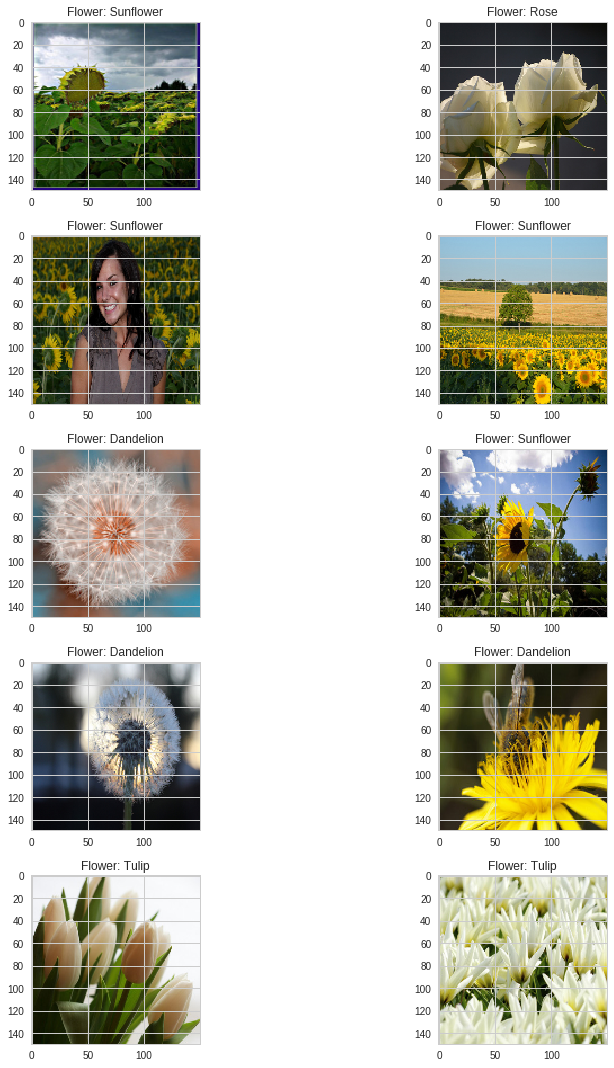

In [0]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [0]:
# Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [0]:
mylist = list(set(Z))
mylist

['Daisy', 'Rose', 'Dandelion', 'Sunflower', 'Tulip']

In [0]:
# Splitting into Training and Validation Sets

# x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 42)

for train_index, test_index in split.split(X,Y):
  x_train = X[train_index]
  x_test = X[test_index]
  y_train = Y[train_index]
  y_test = Y[test_index]

In [0]:
# Setting random seeds

np.random.seed(123)
rn.seed(123)
tf.set_random_seed(123)

In [0]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
image_w, image_h = 150, 150
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model.summary()

# Remove fully-connected layers: include_top = False

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____

In [0]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [0]:
def model_1(learn_rate = 0.01):
  
  # Remove the top layers (fully connected layers) of VGG16 that has already
  # been pretrained on ImageNet
  
  # Trainable layers
  for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
    
  for layer in model.layers[:]:
    layer.trainable = False
    
  for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
  
  new_model_1 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax', name='new_predictions')
  ])
  new_model_1.summary()
    
  for i, layer in enumerate(new_model_1.layers):
    print(i, layer.name, layer.trainable)
  
  new_model_1.compile(loss = "categorical_crossentropy", 
                                          optimizer = 'Adam', 
                                          metrics=["accuracy"])
  
  return new_model_1
  

In [0]:
# Using Grid Search and Early stopping

#You need to pick the right hyper-parameters for your training (try with different ones)

es = EarlyStopping(monitor='acc', verbose=2, patience=5)
mc_1 = ModelCheckpoint('./best_model_vgg16_full_frozen.h5', monitor='acc', verbose=2, 
                     save_best_only=True)

Hyp_Model_1 = KerasClassifier(build_fn=model_1)

learn_rate = [0.00001]
batch_size = [32, 75]
epochs = [5]

param_grid = dict(epochs=epochs, batch_size=batch_size, learn_rate = learn_rate)
fit_model_1 = GridSearchCV(estimator = Hyp_Model_1, 
                                         param_grid=param_grid, cv=5)

grid_result_1 = fit_model_1.fit(x_train,y_train, 
                                                            verbose=2, 
                                                            callbacks=[es,mc_1])

0 input_1 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape

In [0]:
print(grid_result_1.best_params_)
print(grid_result_1.best_estimator_)
print(grid_result_1.best_score_)

{'batch_size': 75, 'epochs': 5, 'learn_rate': 1e-05}
0.7623546506863


In [0]:
final_model_1 = load_model('./best_model_vgg16_full_frozen.h5')

In [0]:
final_model_1_train_results = final_model_1.evaluate(x_train,y_train, verbose=0)

In [0]:
final_model_1_train_results[1]

0.8753633720930233

In [0]:
final_model_1_test_results = final_model_1.evaluate(x_test,y_test, verbose=0)

In [0]:
final_model_1_test_results[1]

0.797385620785175

In [0]:
# Second, unfreeze the last block of VGG16 (block5), re-train and evaluate the model

#for i, layer in enumerate(model.layers):
#   print(i, layer.name, layer.trainable)

In [0]:
#for layer in model.layers[15:19]:
#   layer.trainable = True

In [0]:
#for i, layer in enumerate(model.layers):
#   print(i, layer.name, layer.trainable)

In [0]:
#model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
#model.summary()

In [0]:
def model_2(learn_rate = 0.01):
  
  # Trainable layers
  
  #for layer in model.layers[:]:
  #  layer.trainable = False
 
  #for i, layer in enumerate(model.layers):
  #  print(i, layer.name, layer.trainable)
    
  for layer in model.layers[15:19]:
    layer.trainable = True
    
  for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
  
  new_model_2 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax', name='new_predictions')
  ])
  new_model_2.summary()
  
    
  for i, layer in enumerate(new_model_2.layers):
    print(i, layer.name, layer.trainable)
  
  new_model_2.compile(loss = "categorical_crossentropy", 
                                          optimizer = 'Adam', 
                                          metrics=["accuracy"])
  
  return new_model_2

In [0]:
es = EarlyStopping(monitor='acc', verbose=2, patience=5)
mc_2 = ModelCheckpoint('./best_model_vgg16_last_unfrozen.h5', monitor='acc', verbose=2, 
                     save_best_only=True)

Hyp_Model_2 = KerasClassifier(build_fn=model_2)

learn_rate = [0.00001]
batch_size = [32, 75]
epochs = [5]

param_grid = dict(epochs=epochs, batch_size=batch_size, learn_rate = learn_rate)
fit_model_2 = GridSearchCV(estimator = Hyp_Model_2, 
                                         param_grid=param_grid, cv=5)

grid_result_2 = fit_model_2.fit(x_train,y_train, verbose=2, callbacks=[es,mc_2])

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
____________

In [0]:
print(grid_result_2.best_params_)
print(grid_result_2.best_estimator_)
print(grid_result_2.best_score_)

{'batch_size': 75, 'epochs': 5, 'learn_rate': 1e-05}
0.988372101405159


In [0]:
final_model_2 = load_model('./best_model_vgg16_last_unfrozen.h5')

In [0]:
final_model_2_train_results = final_model_2.evaluate(x_train,y_train, verbose=0)

In [0]:
final_model_2_train_results[1]

0.998546511627907

In [0]:
final_model_2_test_results = final_model_2.evaluate(x_test,y_test, verbose=0)

In [0]:
final_model_2_test_results[1]

0.8224400874056847

In [0]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [0]:
def model_3(learn_rate = 0.01):
  
  # Trainable layers
 
  #for i, layer in enumerate(model.layers):
  #  print(i, layer.name, layer.trainable)
  
  #for layer in model.layers[:]:
  #  layer.trainable = False
    
  #for i, layer in enumerate(model.layers):
  #  print(i, layer.name, layer.trainable)
    
  for layer in model.layers[:]:
    layer.trainable = True
    
  for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
  
  new_model_3 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax', name='new_predictions')
  ])
  new_model_3.summary()
  
  for i, layer in enumerate(new_model_3.layers):
    print(i, layer.name, layer.trainable)
  
  new_model_3.compile(loss = "categorical_crossentropy", 
                                          optimizer = 'Adam', 
                                          metrics=["accuracy"])
  
  return new_model_3

In [0]:
es = EarlyStopping(monitor='acc', verbose=2, patience=25)
mc_3 = ModelCheckpoint('./best_model_vgg16_all_unfrozen.h5', monitor='acc', verbose=2, 
                     save_best_only=True)

Hyp_Model_3 = KerasClassifier(build_fn=model_3)

learn_rate = [0.00001]
batch_size = [32, 75]
epochs = [5]

param_grid = dict(epochs=epochs, batch_size=batch_size, learn_rate = learn_rate)
fit_model_3 = GridSearchCV(estimator = Hyp_Model_3, 
                                         param_grid=param_grid, cv=5)

grid_result_3 = fit_model_3.fit(x_train,y_train, verbose=2, callbacks=[es,mc_3])

0 input_3 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)               0         
___________________________

In [0]:
print(grid_result_3.best_params_)
print(grid_result_3.best_estimator_)
print(grid_result_3.best_score_)

{'batch_size': 75, 'epochs': 5, 'learn_rate': 1e-05}
0.8753633708368207


In [0]:
final_model_3 = load_model('./best_model_vgg16_all_unfrozen.h5')

In [0]:
final_model_3_train_results = final_model_3.evaluate(x_train,y_train, verbose=0)

In [0]:
final_model_3_train_results[1]

0.9785610465116279

In [0]:
final_model_3_test_results = final_model_3.evaluate(x_test,y_test, verbose=0)

In [0]:
final_model_3_test_results[1]

0.7745098041812839

In [0]:
val_results = [grid_result_1.best_score_ * 100, grid_result_2.best_score_ * 100, grid_result_3.best_score_ * 100]
test_results = [final_model_1_test_results[1] * 100, final_model_2_test_results[1] * 100, final_model_3_test_results[1] * 100]
x_name = ['Model 1', 'Model 2', 'Model 3']

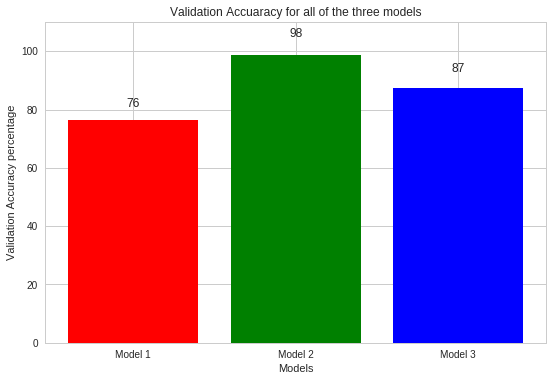

In [0]:
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

#plt.figure(figsize=(10, 5))

fig, ax = plt.subplots()
rects1 = ax.bar(x_name, val_results, color=['red', 'green', 'blue'])

#plt.bar(x_name, val_results, color=['red', 'green', 'blue'])
ax.set_xlabel('Models')
ax.set_ylabel('Validation Accuracy percentage')
ax.set_ylim((0, 110))
ax.set_title('Validation Accuaracy for all of the three models')

autolabel(rects1)

plt.show()

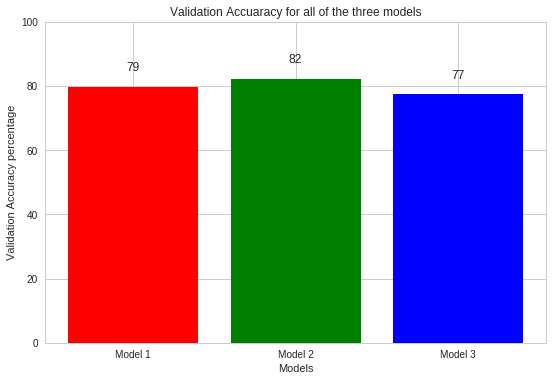

In [0]:
fig, ax = plt.subplots()
rects2 = ax.bar(x_name, test_results, color=['red', 'green', 'blue'])

#plt.bar(x_name, val_results, color=['red', 'green', 'blue'])
ax.set_xlabel('Models')
ax.set_ylabel('Validation Accuracy percentage')
ax.set_ylim((0, 100))
ax.set_title('Validation Accuaracy for all of the three models')

autolabel(rects2)

plt.show()

Let's choose the best performing model and make predictions

In [0]:
# getting predictions on val set.
pred=final_model_2.predict(x_test)
pred_digits=np.argmax(pred,axis=1)
act_digits=np.argmax(y_test,axis=1)

In [0]:
pred.shape

(918, 5)

In [0]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

Correctly classified images

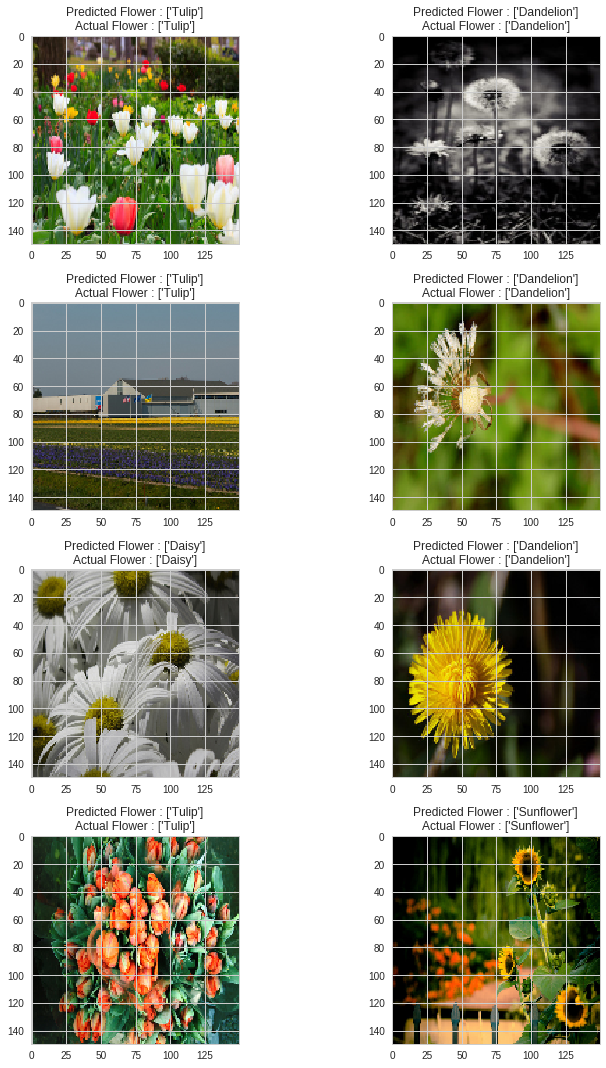

In [0]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([act_digits[prop_class[count]]])))
        plt.tight_layout()
        count+=1

Misclassified images of flowers

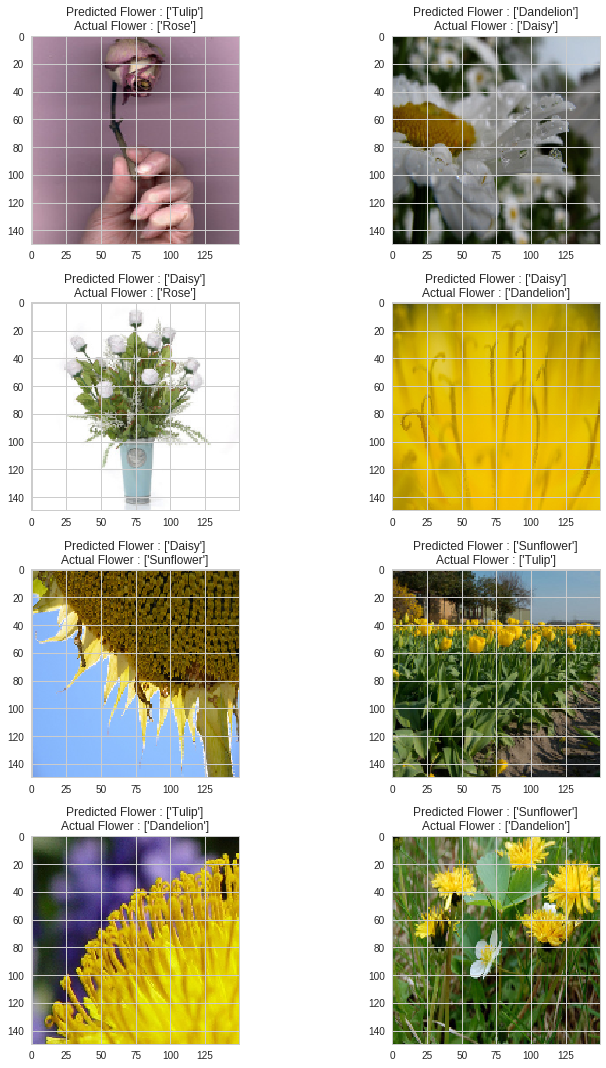

In [0]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([act_digits[mis_class[count]]])))
        plt.tight_layout()
        count+=1

In [0]:
y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict_non_category = [ np.argmax(t) for t in pred ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

In [0]:
conf_mat

array([[113,  18,   8,   9,  10],
       [  4, 202,   4,   7,   8],
       [  3,   4, 114,   3,  36],
       [  4,   5,   4, 157,   5],
       [  1,   4,  18,   8, 169]])

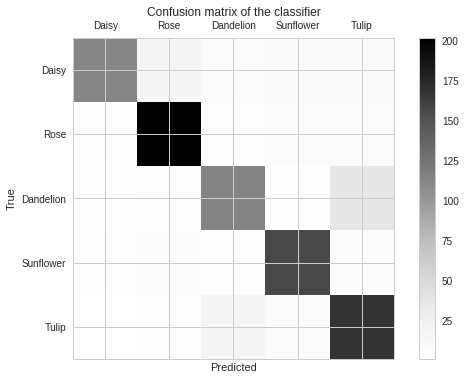

In [0]:
labels = ['Daisy', 'Rose', 'Dandelion', 'Sunflower', 'Tulip']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [0]:
from sklearn import preprocessing

In [0]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

In [0]:
multiclass_roc_auc_score(y_test_non_category, y_predict_non_category)

0.8843721241159663

In [0]:
recall = np.diag(conf_mat) / np.sum(conf_mat, axis = 1)
precision = np.diag(conf_mat) / np.sum(conf_mat, axis = 0)

In [0]:
print(np.mean(recall))
print(np.mean(precision))

0.8135221016676712
0.8271423999420995


As we can see from the above bar graph, the second model has the best performance as its test accuracy is ~82%. Let's compare all of the three models.

- Time

As VGG16 is already pretrained on imagenet, it means it already has existing weights. Therefore, since first model uses pretrained weights, second model requires backprogation on the unfrozen Layer 5 to update the weights, and the last model requires backprogation on all of the unfrozen layers to update the weights for the whole model, it means that the training time will increase as we go from model 1 to model 3 as the weights need to be updated for Model 2 and Model 3.

- Accuracy

Since Model 1 uses frozen layers which have pretrained weights, it means that some of the weights might not be of right fit for the data resulting in lower accuracy. Model 2 provides higher (and in this case highest accuracy) since we backprogate for the layer 5 only thus updating the weights on that last layer and therefore not suffering from vanishing gradients. We need to remember that the later layers of the Convulutional Network become progressively more specific to the details of the classes contained in the dataset. We need to be cautious about the Model 2 since by not updating the weights of most of the network we are only optimizing in a subset of the feature space.Model 3 provides lower accuracy as updates for weights need to be propagated for ALL OF THE unfrozen layers resulting in vanishing gradients, meaning that gradients of the loss function go to 0 resulting in weights not updating properly. One of the ways to solve the issue with the third model is to use more data by either introducing new data or by performing data augmentation. Ideally, unfreezing everything would allow us to optimize in the whole feature space, allowing us to find better optima; but, the fact that we are facing vanishing gradients issue hinders our model from performing optimally and therefore finding better optima.

Another thing to note is that we cannot have extensive grid search space due to RAM ramifications in Google Colab. Another issue that I noticed is that if I run 2nd and 3rd model after another, I would receive good results on the 2nd model but subpar results (around 25% accuracy on the train and test sets) on the third model. To resolve this, I had to run all of the models, and then run the VGG16 model again and run the third model again (had to do this twice as in the first call of the VGG16 model it still would give me bad results). I suspect that the further fine tuning of the third model is required due to its depth. For example, I could increase the number of epochs and batches in order to improve the learning. But, alas, the RAM ramifications would not allow me to do this. .